In [159]:
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
import torchmetrics
import matplotlib.pyplot as plt
from functools import partial
from transformers import AutoTokenizer

from scripts.utils import MultimodalRegressionModel, train
from scripts.dataset import MultimodalDataset, get_transforms, collate_fn

# Этап 1. EDA

In [27]:
img_path = 'data/images'

In [31]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

In [32]:
images = ImageFolder(img_path, transform=transform)
dataloader = torch.utils.data.DataLoader(images, batch_size=4, shuffle=True)

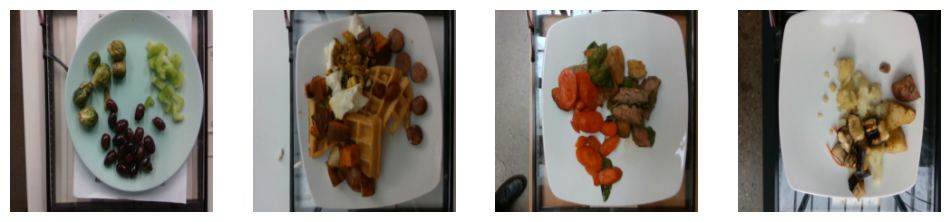

In [33]:
images, labels = next(iter(dataloader))

fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
for i, (image, label) in enumerate(zip(images, labels)):
    img = image.permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
plt.show()

## Выводы

- как вы будете решать задачу

    Буду решать задачу регрессии - картинку и список ингредиентов можно представить в виде одного эмбеддинга и по нему предсказать единое число (кол-во калорий).

- какие подходы к обогащению/аугментации данных примените и почему

    Датасет состоит из однотипных фотографий: тарелка (круглая или прямоугольная) с едой, вид сверху. Фотографии отличаются между собой яркостью освещения и положением еды на тарелке. При аугментации имеет смысл добавить в датасет легкую вариацию в контрастности/яркости/насыщенности (чтобы учесть разное освещение), а также повороты, чтобы модель могла учесть различные положения ингредиента на тарелке

- на какие метрики будете ориентироваться при обучении

    На метрику MAE (Mean Absolute Error).

# Этап 2. Обучение модели

In [141]:
class Config:
    # для воспроизводимости
    SEED = 42

    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b0"

    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"

    # Гиперпараметры
    BATCH_SIZE = 64
    TEXT_LR = 3e-4
    IMAGE_LR = 1e-3
    REGRESSOR_LR = 1e-2
    EPOCHS = 20
    DROPOUT = 0.0
    HIDDEN_DIM = 256

    # Пути
    DF_PATH = "data/dish.csv"
    SAVE_PATH = "best_model.pth"


device = "cuda" if torch.cuda.is_available() else "cpu"
cfg = Config()

In [10]:
train(cfg, device) 

Разморожен слой: encoder.layer.11.attention.self.query.weight
Разморожен слой: encoder.layer.11.attention.self.query.bias
Разморожен слой: encoder.layer.11.attention.self.key.weight
Разморожен слой: encoder.layer.11.attention.self.key.bias
Разморожен слой: encoder.layer.11.attention.self.value.weight
Разморожен слой: encoder.layer.11.attention.self.value.bias
Разморожен слой: encoder.layer.11.attention.output.dense.weight
Разморожен слой: encoder.layer.11.attention.output.dense.bias
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.11.intermediate.dense.weight
Разморожен слой: encoder.layer.11.intermediate.dense.bias
Разморожен слой: encoder.layer.11.output.dense.weight
Разморожен слой: encoder.layer.11.output.dense.bias
Разморожен слой: encoder.layer.11.output.LayerNorm.weight
Разморожен слой: encoder.layer.11.output.LayerNorm.bias
Разморожен слой: pooler.dense.weight
Раз

# Этап 3. Валидация качества

In [3]:
model = MultimodalRegressionModel(cfg)

model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_NAME)

In [151]:
transforms = get_transforms(cfg, ds_type="test")

test_dataset = MultimodalDataset(cfg, transforms, ds_type="test")
test_loader = DataLoader(test_dataset,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=partial(collate_fn,
                                                tokenizer=tokenizer))

mae_metric = torchmetrics.MeanAbsoluteError().to(device)

In [152]:
def validate(model, val_loader, device, mae_metric):
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_indices = []
    all_images = []
    all_mae_scores = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device),
                'image': batch['image'].to(device)
            }
            targets = batch['total_calories'].to(device)
            
            indices = [batch_idx]
            
            predictions = model(**inputs)
            
            batch_mae = torch.abs(predictions - targets).cpu().numpy()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu())
            all_indices.extend(indices)
            all_mae_scores.extend(batch_mae)
            all_images.extend(batch['image'].cpu())
            
            _ = mae_metric(predictions, targets)

    all_mae_scores = np.array(all_mae_scores)
    all_indices = np.array(all_indices)
    
    worst_indices = np.argsort(all_mae_scores)[-5:]
    
    for i, idx in enumerate(worst_indices):
        print(f"Номер {i+1}:")
        print(f"Индекс: {all_indices[idx]}")
        print(f"MAE: {all_mae_scores[idx]:.4f}")
        print(f"Предсказано: {all_predictions[idx]}")
        print(f"Target: {all_targets[idx]}")
    
    return mae_metric.compute().cpu().numpy()

## 5 примеров с наибольшей MAE

In [153]:
MAE = validate(model, test_loader, device, mae_metric)

Номер 1:
Индекс: 22
MAE: 588.1384
Предсказано: 248.8616485595703
Target: 837
Номер 2:
Индекс: 88
MAE: 602.0886
Предсказано: 347.9114074707031
Target: 950
Номер 3:
Индекс: 58
MAE: 609.3688
Предсказано: 106.63117218017578
Target: 716
Номер 4:
Индекс: 54
MAE: 660.7454
Предсказано: 352.25457763671875
Target: 1013
Номер 5:
Индекс: 479
MAE: 683.5127
Предсказано: 366.4873046875
Target: 1050


In [154]:
MAE

array(116.613846, dtype=float32)

In [155]:
df = pd.read_csv('data/dish.csv')
df_test = df.loc[df['split']=='test'].reset_index()

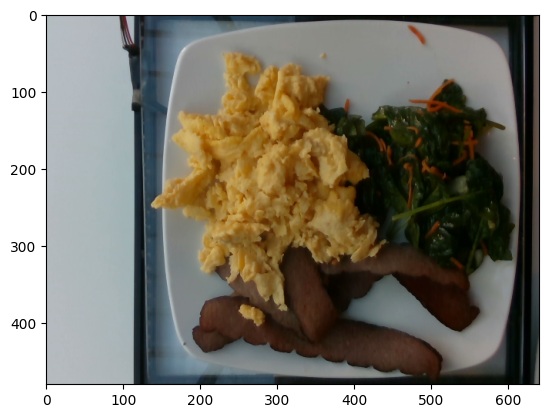

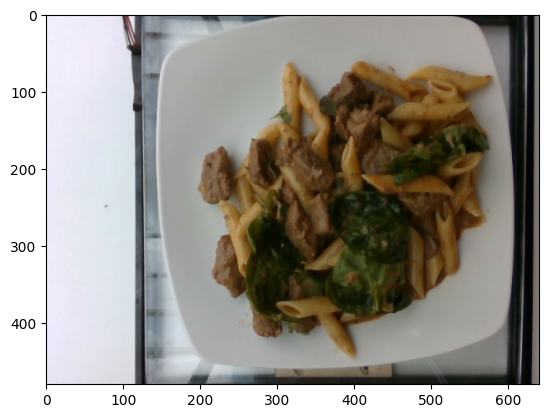

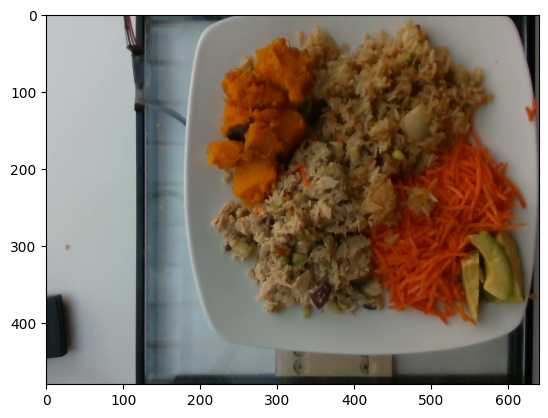

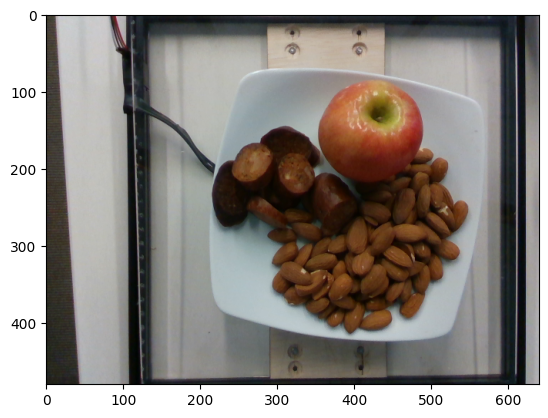

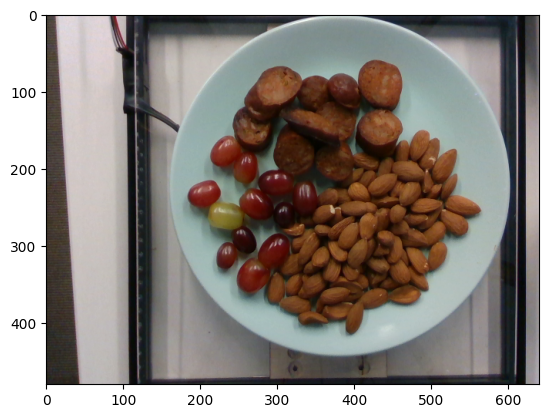

In [162]:
for idx in [22, 88, 58, 54, 479]:
    dish_id = df_test.loc[idx]['dish_id']
    image = Image.open(f"data/images/{dish_id}/rgb.png").convert('RGB')
    plt.imshow(image)
    plt.show()

## Выводы

Модель показывает наихудшие результаты при предсказании числа калорий высококалорийных блюд. Возможная причина низкого качества на этих примерах: при обучении не бралась в расчет масса блюда. Этот признак мог бы позволить нейросети более точно предсказывать калорийность "тяжелых" блюд.